# Label-noise robust regression

The class labels in the training data are commonly assumed to be perfectly correct. This is not always a justified assumption. Humans, who have assigned the labels, may have made mistakes for example, because the assignment is not obvious or because the labeler is not an expert on the task.

It is possible to model labeling mistakes by altering the classifier. This notebook explores one way to extend a multiclass logistic regression classifier to account for class-dependent label noise. The classifier and label flipping probabilities are learned jointly. We'll evaluate the robust regression model on simulated data where we inject a controlled amount of label-noise.

This is based on the [Label-Noise Robust Logistic Regression and Its Applications](https://www.cs.bham.ac.uk/~axk/ecml2012.pdf) (ECML PKDD 2012) paper by Bootkrajang and Kabán.

In [1]:
%matplotlib inline

import pystan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set(style='white', font_scale=1.2)

## Data

Let's evaluate robust regression model on the well know iris data set. The data consists of measurements of physical properties of three iris subspecies.

In [3]:
iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'],
                                                    test_size=0.3,
                                                    stratify=iris['target'],
                                                    random_state=1234)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=iris['feature_names'])
X_test = pd.DataFrame(scaler.transform(X_test), columns=iris['feature_names'])

print(f'Train sample dim: {X_train.shape}')
print(f'Train class proportions: {iris["target_names"][0]}: {(y_train == 0).mean():.2f}, {iris["target_names"][1]}: {(y_train == 1).mean():.2f}, {iris["target_names"][2]}: {(y_train == 2).mean():.2f}')
print()
print(f'Test samples: {len(y_test)}')
print(f'Test class proportions: {iris["target_names"][0]}: {(y_test == 0).mean():.2f}, {iris["target_names"][1]}: {(y_test == 1).mean():.2f}, {iris["target_names"][2]}: {(y_test == 2).mean():.2f}')

Train sample dim: (105, 4)
Train class proportions: setosa: 0.33, versicolor: 0.33, virginica: 0.33

Test samples: 45
Test class proportions: setosa: 0.33, versicolor: 0.33, virginica: 0.33


In [4]:
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,2.269240,-0.139495,1.359239,1.493210
1,-1.143326,1.277951,-1.330354,-1.427463
2,0.562957,-0.611977,0.786985,0.431147
3,1.294221,0.096746,0.958662,1.227694
4,0.441080,0.805469,0.958662,1.493210


## Standard logistic regression

The text book logistic regression model assumes that the observed label $y$ has been generated by a categorical logit distribution.

![logistic regression plate notation](images/logistic.png)

\begin{equation*}
y \sim \text{categorical}(\text{softmax}(\beta^T X))
\end{equation*}

We'll apply weak L2 regularization on the weights $\beta$.

In [5]:
logreg = LogisticRegression(C=10)
logreg.fit(X_train, y_train)
ypred_train = logreg.predict(X_train)
ypred_test = logreg.predict(X_test)

print(f'intercept = {logreg.intercept_}')
print(f'beta = {logreg.coef_}')

print()
print('Train')
print(classification_report(y_train, ypred_train, target_names=iris['target_names']))

print()
print('Test')
print(classification_report(y_test, ypred_test, target_names=iris['target_names']))

intercept = [ 0.17747598  3.49435879 -3.67183477]
beta = [[-1.48233253  1.96237383 -2.99806637 -3.04462235]
 [ 1.27602909 -0.6185466  -1.46313308 -1.32148973]
 [ 0.20630344 -1.34382723  4.46119945  4.36611207]]

Train
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        35
  versicolor       0.97      0.94      0.96        35
   virginica       0.94      0.97      0.96        35

    accuracy                           0.97       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.97      0.97      0.97       105


Test
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



## Robust logistic regression

The robust logistic regression variant by Bootkrajang and Kabán assumes that the observed labels are corrupted versions of the true labels. The true labels are latent variables generated by the standard logistic regression model. The latent labels are then corrupted by a noise process that flips a label to another with a class-dependent probability.

The flip probability $p(y = j | z = i)$ is denoted by $\gamma_{ij}$ below. The flip probabilities are parameters to be estimated during the training. The flip probabilities can be asymmetric, that is, the probability for switching from A to B doesn't have to equal to the B-to-A probability.

![robust regression plate notation](images/robust.png)

\begin{align*}
z &\sim \text{categorical}(\text{softmax}(\beta^T X))\\
y &\sim \text{categorical}(\gamma_{z \cdot})
\end{align*}

The following defines and compiles the robust regression probabilistic as a Stan model. The latent label $z$ has been marginalized out by summing over its possible values. We apply the same L2 regularization as before on the regression weights $\beta$ and a Dirichlet prior on the flip probabilities $\gamma$.

In [6]:
robust_code = """
data {
    int<lower=0> N;  // number of observations
    int<lower=1> D;  // number of predictors
    int<lower=2> K;  // number of classes
    matrix[N, D] X;
    int<lower=1,upper=K> y[N];  // observed (noisy) class labels
    real prior_sigma;
    real transition_prior;
}
parameters {
    vector[K] alpha;
    matrix[D, K] beta;
    simplex[K] gamma[K];
}
model {
    matrix[N, K] x_beta = rep_matrix(to_row_vector(alpha), N) + X * beta;
    
    alpha ~ normal(0, prior_sigma);
    to_vector(beta) ~ normal(0, prior_sigma);
    for (i in 1:K) {
        gamma[i] ~ dirichlet(rep_vector(transition_prior, K));
    }

    for (n in 1:N) {
        vector[K] u = rep_vector(0.0, K);
        vector[K] w = softmax(x_beta[n]');
        
        for (j in 1:K) {
            u += w[j] * gamma[j];
        }
                
        y[n] ~ categorical(u);
    }
}
"""

sm = pystan.StanModel(model_code=robust_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_811ef81dc39844af59dc6dadfede0a89 NOW.


This defines a class that wraps a Stan model into a scikit-learn-like interface. Having an uniform interface simplifies comparison against scikit-learn-provided classifiers.

In [7]:
class StanClassifierWrapper():
    def __init__(self, stan_model, prior_sigma=1, transition_prior=1, restarts=1):
        self.sm = stan_model
        self.intercept_ = None
        self.coef_ = None
        self.gamma_ = None
        self.prior_sigma = prior_sigma
        self.transition_prior = transition_prior
        self.restarts = restarts

    def fit(self, X, y):
        K = len(np.unique(y))
        data = {
            'N': X.shape[0],
            'D': X.shape[1],
            'K': K,
            'X': X,
            'y': y + 1,
            'prior_sigma': self.prior_sigma,
            'transition_prior': self.transition_prior
        }
        
        best_par = None
        best_lp = None
        for _ in range(max(self.restarts, 1)):
            res = sm.optimizing(data=data, init=self.param_initializer(K, X.shape[1]), as_vector=False)
            if best_lp is None or res['value'] > best_lp:
                best_par = res['par']
                best_lp = res['value']
            
        self.intercept_ = best_par['alpha']
        self.coef_ = best_par['beta'].T
        if 'gamma' in best_par:
            self.gamma_ = best_par['gamma']

    def predict(self, X):
        return np.asarray((self.intercept_ + X.dot(self.coef_.T)).idxmax(axis=1))
    
    def param_initializer(self, num_classes, num_features):
        def wrapped():
            ginit = 0.01/(num_classes-1)*np.ones((num_classes, num_classes))
            np.fill_diagonal(ginit, 0.99)
            return {
                'alpha': np.random.uniform(-2, 2, num_classes),
                'beta': np.random.uniform(-2, 2, (num_features, num_classes)),
                'gamma': ginit
            }
        
        return wrapped

In [8]:
clf = StanClassifierWrapper(sm, prior_sigma=10, transition_prior=2, restarts=6)
clf.fit(X_train, y_train)

ypred_train = clf.predict(X_train)
ypred_test = clf.predict(X_test)

print(f'intercept = {clf.intercept_}')
print(f'beta = {clf.coef_}')
print(f'gamma = {clf.gamma_}')

print()
print('Train')
print(classification_report(y_train, ypred_train, target_names=iris['target_names']))

print()
print('Test')
print(classification_report(y_test, ypred_test, target_names=iris['target_names']))

intercept = [ 0.20269726  5.16454015 -5.36591278]
beta = [[-2.00913541  2.63564609 -4.43352133 -4.58595021]
 [ 2.12933744 -0.99219196 -2.80732769 -1.48079939]
 [-0.12114294 -1.64565091  7.23894687  6.0666031 ]]
gamma = [[0.94734464 0.02633983 0.02631553]
 [0.02643188 0.94544116 0.02812697]
 [0.02622582 0.03135414 0.94242004]]

Train
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        35
  versicolor       0.97      0.97      0.97        35
   virginica       0.97      0.97      0.97        35

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105


Test
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   mac

## Evaluation on simulated data

We validate the impact of the robustness modeling on simulated data. The robust and standard logistic regression models are compared on different levels of artificially injected label noise.

In real applications, acquiring a test set with clean labels can be a considerable challenge, because the same noise process that has corrupted the training dataset is likely to affect the test set, too. However, a testset with clean labels is necessary for fair evaluation of generalization performance. With artificially injected noise we don't have such challenges with regards to the testset. Noise is only inject on the training labels and the trained model is evaluated on noise-free test data.

In [9]:
def draw_transition_prob(size):
    U = np.zeros([size, size])
    for i in range(size):
        ind = [x for x in range(size) if x != i]
        U[i, ind] = np.random.dirichlet(0.5*np.ones(size - 1))
    return U

def draw_noisy_labels(y_true, noise_prob, transition_prob):
    K = transition_prob.shape[0]
    N = len(y_true)

    y_noisy = np.array(y_true)
    for i in np.random.choice(N, size=int(noise_prob*N), replace=False):
        y_noisy[i] = np.random.choice(range(K), p=transition_prob[y_true[i], :])

    return y_noisy

def eval_test_error(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    ypred = clf.predict(X_test)
    return 1 - accuracy_score(y_test, ypred)

In [10]:
n_repeats = 40
noise_proportions = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

errors = []
for i, flip_prob in enumerate(noise_proportions):
    scores = []
    for _ in range(n_repeats):
        T = draw_transition_prob(3)
        y_noisy = draw_noisy_labels(y_train, flip_prob, T)
        noise_level = 1.0 - (y_noisy == y_train).mean()

        robust = StanClassifierWrapper(sm, prior_sigma=10, transition_prior=2, restarts=6)
        r_err = eval_test_error(robust, X_train, y_noisy, X_test, y_test)
        errors.append({
            'Model': 'Robust regression',
            'Noise level (%)': 100*noise_level,
            'Test error (%)': 100*r_err
        })
        
        logreg = LogisticRegression(C=10)
        r_err = eval_test_error(logreg, X_train, y_noisy, X_test, y_test)
        errors.append({
            'Model': 'Logistic regression',
            'Noise level (%)': 100*noise_level,
            'Test error (%)': 100*r_err
        })

errors = pd.DataFrame(errors)

The following plot displays the accuracy of the two models on the test set at different noise levels. The shaded region is the variation due to noise (transition matrix) generation process.

The robust model performs very close to the noise-free condition when 10% of labels are changed. The performance of the standard logistic regression model has already deteriorated quite much at the same amount of noise. Even when 30% of labels are changed to be incorrect, the robust classifier attains test error below 10%.

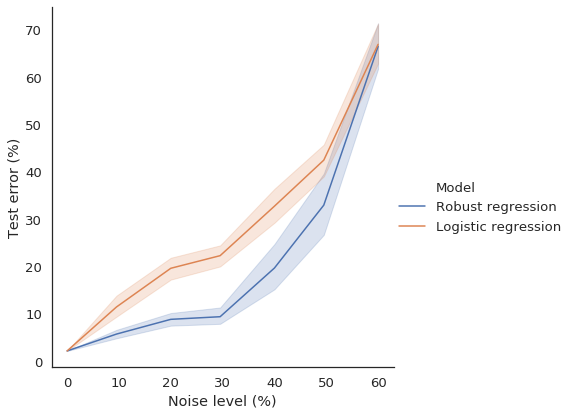

In [11]:
sns.relplot(x='Noise level (%)', y='Test error (%)', hue='Model', kind='line', data=errors, height=6);